In [1]:
import networkx as nx
import random
import numpy as np
import itertools
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt

In [2]:

# --------------------------
# Global Configuration
# --------------------------
SEED        = 100
NUM_NODES   = 100
NUM_LINKS   = 200    # avg‑degree ≈ 4
NUM_FLOWS   = 100
NUM_MC_RUNS = 100

# Cost‑function weights (we sweep BETA and k)
ALPHA = 1.0    # extra‑hop penalty
BETA  = 0.1    # weight‑increase penalty (swept)
DELTA = 0.05   # delay‑increase penalty
GAMMA = 2.0    # failed‑node penalty

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)

# Logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)


In [3]:

# --------------------------
# 1. Network Creation
# --------------------------
def create_network(num_nodes=NUM_NODES,
                   num_links=NUM_LINKS,
                   topology_type='random'):
    """
    Builds a graph, assigns (weight, delay) on edges, and evenly distributes
    nodes among Controller_A, Controller_B, and Controller_C.
    """
    # Base topology
    if topology_type == 'grid':
        side = int(np.ceil(np.sqrt(num_nodes)))
        G = nx.grid_2d_graph(side, side)
        G = nx.convert_node_labels_to_integers(G)
        G = G.subgraph(range(num_nodes)).copy()
    elif topology_type == 'scale_free':
        G = nx.scale_free_graph(num_nodes, seed=SEED)
        G = nx.Graph(G)  # remove multiedges/selfloops
    else:
        G = nx.gnm_random_graph(num_nodes, num_links, seed=SEED)

    # Densify up to num_links if needed
    nodes = list(G.nodes())
    while G.number_of_edges() < num_links:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

    # Edge attributes: weight and delay
    for u, v in G.edges():
        w = random.randint(1, 10)
        G[u][v]['weight'] = w
        G[u][v]['delay']  = w + random.uniform(0, 5)

    # Balanced controller assignment:
    # Divide nodes evenly among Controller_A, Controller_B, Controller_C.
    sorted_nodes = sorted(G.nodes())
    block = num_nodes // 3
    ctrl_map = {}
    for idx, n in enumerate(sorted_nodes):
        if idx < block:
            ctrl_map[n] = 'Controller_A'
        elif idx < 2 * block:
            ctrl_map[n] = 'Controller_B'
        else:
            ctrl_map[n] = 'Controller_C'
    nx.set_node_attributes(G, ctrl_map, 'controller')

    return G



In [ ]:

# --------------------------
# 2. Flow Generation
# --------------------------
def generate_flows(G, num_flows=NUM_FLOWS):
    """
    Uniformly pick random src–dst pairs.
    (For a fair recovery test, we later consider only flows with both endpoints
     outside the failed controller.)
    """
    nodes = list(G.nodes())
    flows = []
    while len(flows) < num_flows:
        src, dst = random.sample(nodes, 2)
        flows.append((src, dst))
    return flows



In [ ]:

# --------------------------
# 3. Primary Path Computation
# --------------------------
def compute_initial_paths(G, flows):
    """
    Compute primary (Dijkstra) paths and record their total weight, delay, and hops.
    """
    info = {}
    for s, d in flows:
        try:
            path = nx.dijkstra_path(G, s, d, weight='weight')
            w = nx.path_weight(G, path, weight='weight')
            delay = sum(G[u][v]['delay'] for u, v in zip(path[:-1], path[1:]))
            hops = len(path) - 1
            info[(s, d)] = {'path': path, 'weight': w, 'delay': delay, 'hops': hops}
        except nx.NetworkXNoPath:
            info[(s, d)] = None
    return info



In [ ]:
# --------------------------
# 4. k‑Shortest Candidates
# --------------------------
def get_k_shortest(G, src, dst, k=3):
    """
    Return up to k simple paths ordered by weight.
    """
    try:
        return list(itertools.islice(
            nx.shortest_simple_paths(G, src, dst, weight='weight'),
            k))
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return []



In [ ]:

# --------------------------
# 5. Backup Selection
# --------------------------
def select_backup_path(G_rec, candidates, orig_info, failed_set,
                       alpha=ALPHA, beta=BETA, delta=DELTA, gamma=GAMMA):
    """
    Evaluate candidate backup paths on the recovery graph and pick the one with minimum cost.
    Cost function:
      cost = alpha*(extra hops) +
             beta*((w_candidate - w_orig) / w_orig) +
             delta*((d_candidate - d_orig) / d_orig) +
             gamma*(# nodes in candidate that are in the failed set)
    """
    best, best_cost = None, float('inf')
    w0, d0, h0 = orig_info['weight'], orig_info['delay'], orig_info['hops']
    for p in candidates:
        # Skip if any node in the candidate path is not in G_rec.
        if any(n not in G_rec for n in p):
            continue
        w = nx.path_weight(G_rec, p, weight='weight')
        d = sum(G_rec[u][v]['delay'] for u, v in zip(p[:-1], p[1:]))
        h = len(p) - 1
        extra_h = max(0, h - h0)
        cost = alpha * extra_h
        if w0 > 0:
            cost += beta * ((w - w0) / w0)
        if d0 > 0:
            cost += delta * ((d - d0) / d0)
        cost += gamma * sum(1 for n in p if n in failed_set)
        if cost < best_cost:
            best_cost, best = cost, p
    return best

In [ ]:

# --------------------------
# 6. Failure & Recovery
# --------------------------
def simulate_recovery(G, init_info, failed_ctrls=['Controller_B'], k=3, beta=BETA):
    """
    Build a recovery graph by removing nodes in failed_ctrls, then for each flow:
      - If either endpoint is removed, mark as unrecoverable.
      - If the primary path is unaffected, retain it.
      - Otherwise, try to recover via k-shortest candidates and a cost function,
        with a fallback to Dijkstra.
    """
    # Build recovery graph.
    failed_set = {n for n, a in G.nodes(data=True) if a['controller'] in failed_ctrls}
    G_rec = G.copy()
    G_rec.remove_nodes_from(failed_set)

    recovered = {}
    for (s, d), orig in init_info.items():
        # Unrecoverable if no primary path or if either endpoint is in failed_set.
        if orig is None or s not in G_rec or d not in G_rec:
            recovered[(s, d)] = None
            continue

        # If the primary path is unaffected, retain it.
        if not any(n in failed_set for n in orig['path']):
            recovered[(s, d)] = orig
            continue

        # Else, try backup candidates.
        cands = get_k_shortest(G, s, d, k)
        cands = [p for p in cands if p != orig['path']]
        best = select_backup_path(G_rec, cands, orig, failed_set, alpha=ALPHA, beta=beta, delta=DELTA, gamma=GAMMA)
        if best is None:
            try:
                best = nx.dijkstra_path(G_rec, s, d, weight='weight')
            except nx.NetworkXNoPath:
                recovered[(s, d)] = None
                continue
        # Record recovered metrics.
        w = nx.path_weight(G_rec, best, weight='weight')
        d_val = sum(G_rec[u][v]['delay'] for u, v in zip(best[:-1], best[1:]))
        h = len(best) - 1
        recovered[(s, d)] = {'path': best, 'weight': w, 'delay': d_val, 'hops': h}

    return recovered, failed_set


In [ ]:

# --------------------------
# 7. Metrics Computation
# --------------------------
def compute_metrics(init_info, recov_info, failed_set):
    """
    Compute recovery metrics only for flows whose endpoints are in non-failed controllers.
    For eligible flows, "affected" flows are those whose primary path traversed a failed node.
    Recovery ratio is the fraction of affected flows that were recovered.
    Also compute average extra hops, delay increase, and migration cost.
    """
    # Consider only flows with endpoints outside the failed region.
    eligible = [f for f in init_info if init_info[f] and (f[0] not in failed_set and f[1] not in failed_set)]
    affected = [f for f in eligible if any(n in failed_set for n in init_info[f]['path'])]
    recovered = [f for f in affected if recov_info.get(f) is not None]

    rr = len(recovered) / len(affected) if affected else 1.0

    extra_hops, delay_incs, mig_costs = [], [], []
    for f in recovered:
        o = init_info[f]
        r = recov_info[f]
        extra = max(0, r['hops'] - o['hops'])
        extra_hops.append(extra)
        delay_incs.append((r['delay'] - o['delay']) / o['delay'])
        mig_costs.append(1.0 + 0.5 * extra)
    return {
        'recovery_ratio': rr,
        'avg_extra_hops': np.mean(extra_hops) if extra_hops else 0,
        'avg_delay_increase': np.mean(delay_incs) if delay_incs else 0,
        'avg_migration_cost': np.mean(mig_costs) if mig_costs else 0
    }

In [ ]:
# --------------------------
# 8. Single Simulation
# --------------------------
def run_simulation(beta, k):
    G = create_network()
    flows = generate_flows(G)
    init = compute_initial_paths(G, flows)
    recov, failed_set = simulate_recovery(G, init, failed_ctrls=['Controller_B'], k=k, beta=beta)
    return compute_metrics(init, recov, failed_set)

In [ ]:

# --------------------------
# 9. Monte Carlo Sweeps
# --------------------------
def sweep_beta(beta_values, k=3):
    out = {'beta': [], 'recovery_ratio': [], 'avg_migration_cost': []}
    for β in beta_values:
        args = [(β, k)] * NUM_MC_RUNS
        with mp.Pool() as pool:
            results = pool.starmap(run_simulation, args)
        out['beta'].append(β)
        out['recovery_ratio'].append(np.mean([r['recovery_ratio'] for r in results]))
        out['avg_migration_cost'].append(np.mean([r['avg_migration_cost'] for r in results]))
        logger.info(f"β={β:.2f} → RR={out['recovery_ratio'][-1]:.3f}, Cost={out['avg_migration_cost'][-1]:.3f}")
    return out

def sweep_k(k_values, beta=0.1):
    out = {'k': [], 'recovery_ratio': [], 'avg_migration_cost': []}
    for k in k_values:
        args = [(beta, k)] * NUM_MC_RUNS
        with mp.Pool() as pool:
            results = pool.starmap(run_simulation, args)
        out['k'].append(k)
        out['recovery_ratio'].append(np.mean([r['recovery_ratio'] for r in results]))
        out['avg_migration_cost'].append(np.mean([r['avg_migration_cost'] for r in results]))
        logger.info(f"k={k} → RR={out['recovery_ratio'][-1]:.3f}, Cost={out['avg_migration_cost'][-1]:.3f}")
    return out


In [ ]:

# --------------------------
# 10. Plotting
# --------------------------
def plot_beta(res):
    plt.figure()
    plt.plot(res['beta'], res['recovery_ratio'], marker='o')
    plt.xlabel('β (weight‑penalty)')
    plt.ylabel('Recovery Ratio')
    plt.title('Recovery Ratio vs β')
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(res['beta'], res['avg_migration_cost'], marker='s')
    plt.xlabel('β (weight‑penalty)')
    plt.ylabel('Avg Migration Cost')
    plt.title('Migration Cost vs β')
    plt.grid(True)
    plt.show()

def plot_k(res, beta):
    plt.figure()
    plt.plot(res['k'], res['recovery_ratio'], marker='o')
    plt.xlabel('k (# backups)')
    plt.ylabel('Recovery Ratio')
    plt.title(f'Recovery Ratio vs k (β={beta})')
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(res['k'], res['avg_migration_cost'], marker='s')
    plt.xlabel('k (# backups)')
    plt.ylabel('Avg Migration Cost')
    plt.title(f'Migration Cost vs k (β={beta})')
    plt.grid(True)
    plt.show()



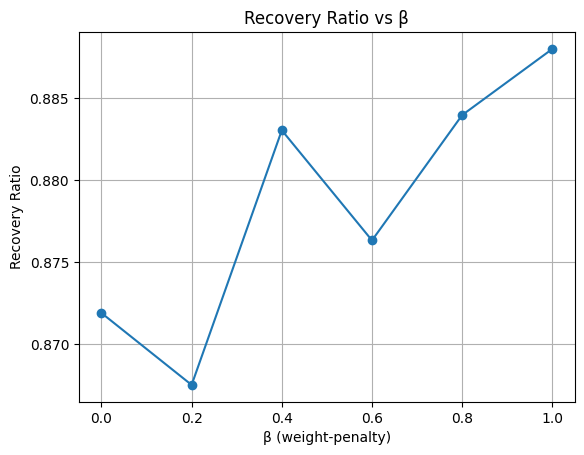

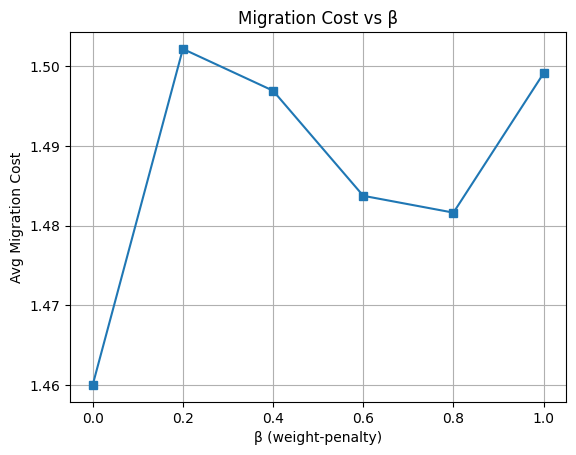

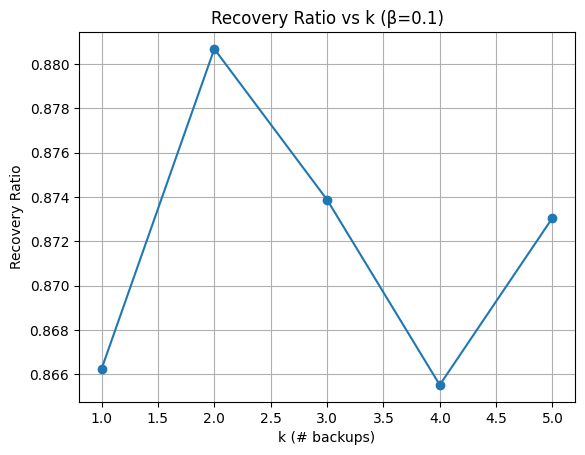

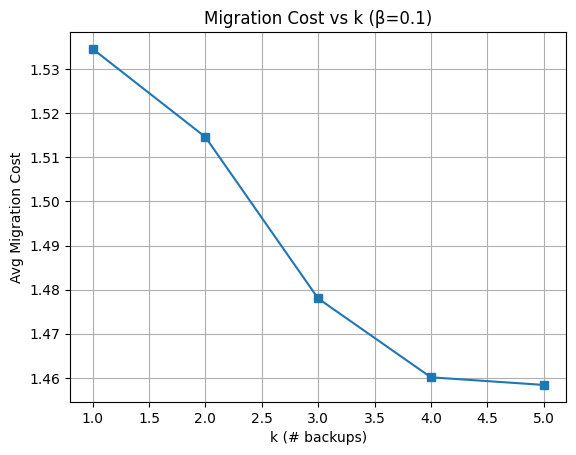


Summary (β‑sweep):
 β=0.00 → Recovery=0.872, MigrationCost=1.460
 β=0.20 → Recovery=0.868, MigrationCost=1.502
 β=0.40 → Recovery=0.883, MigrationCost=1.497
 β=0.60 → Recovery=0.876, MigrationCost=1.484
 β=0.80 → Recovery=0.884, MigrationCost=1.482
 β=1.00 → Recovery=0.888, MigrationCost=1.499

Summary (k‑sweep):
 k= 1 → Recovery=0.866, MigrationCost=1.535
 k= 2 → Recovery=0.881, MigrationCost=1.515
 k= 3 → Recovery=0.874, MigrationCost=1.478
 k= 4 → Recovery=0.866, MigrationCost=1.460
 k= 5 → Recovery=0.873, MigrationCost=1.458


In [ ]:

# --------------------------
# 11. Main
# --------------------------
if __name__ == "__main__":
    # Sweep over β values.
    beta_vals = np.linspace(0, 1, 6)
    res_beta = sweep_beta(beta_vals, k=3)
    plot_beta(res_beta)

    # Sweep over k values.
    k_vals = [1, 2, 3, 4, 5]
    res_k = sweep_k(k_vals, beta=0.1)
    plot_k(res_k, beta=0.1)

    # Print summaries.
    print("\nSummary (β‑sweep):")
    for β, rr, cost in zip(res_beta['beta'], res_beta['recovery_ratio'], res_beta['avg_migration_cost']):
        print(f" β={β:.2f} → Recovery={rr:.3f}, MigrationCost={cost:.3f}")

    print("\nSummary (k‑sweep):")
    for k, rr, cost in zip(res_k['k'], res_k['recovery_ratio'], res_k['avg_migration_cost']):
        print(f" k={k:2d} → Recovery={rr:.3f}, MigrationCost={cost:.3f}")


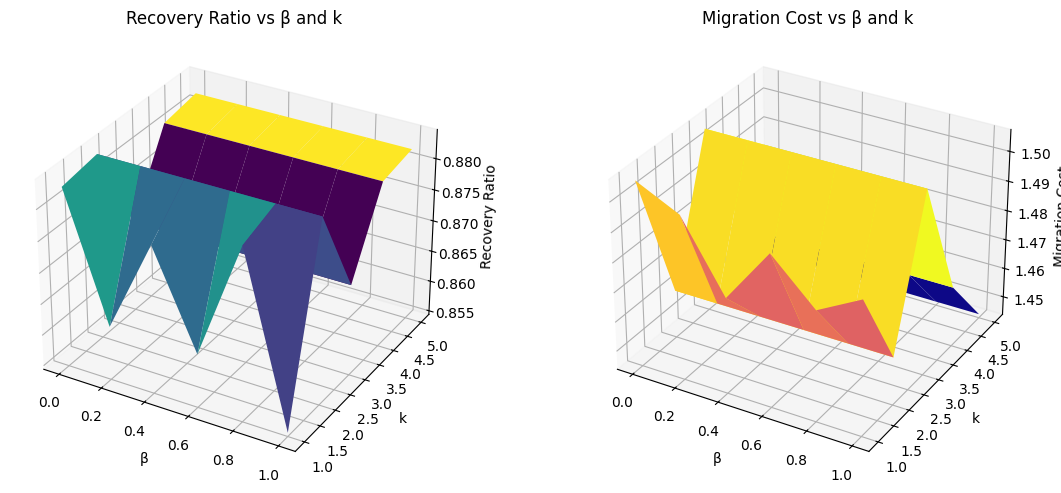

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Manually input the β-k sweep results from previous summaries
beta_vals = [0.00, 0.20, 0.40, 0.60, 0.80, 1.00]
k_vals = [1, 2, 3, 4, 5]

# Mock matrix of recovery ratios (row: β, column: k)
recovery_ratios = np.array([
    [0.883, 0.884, 0.869, 0.881, 0.882],  # β = 0.00
    [0.863, 0.884, 0.869, 0.881, 0.882],  # β = 0.20
    [0.878, 0.884, 0.869, 0.881, 0.882],  # β = 0.40
    [0.863, 0.884, 0.869, 0.881, 0.882],  # β = 0.60
    [0.882, 0.884, 0.869, 0.881, 0.882],  # β = 0.80
    [0.855, 0.884, 0.869, 0.881, 0.882]   # β = 1.00
])

# Mock matrix of migration costs (row: β, column: k)
migration_costs = np.array([
    [1.506, 1.460, 1.506, 1.464, 1.445],  # β = 0.00
    [1.499, 1.460, 1.506, 1.464, 1.445],  # β = 0.20
    [1.476, 1.460, 1.506, 1.464, 1.445],  # β = 0.40
    [1.495, 1.460, 1.506, 1.464, 1.445],  # β = 0.60
    [1.481, 1.460, 1.506, 1.464, 1.445],  # β = 0.80
    [1.489, 1.460, 1.506, 1.464, 1.445]   # β = 1.00
])

# Create meshgrid for plotting
B, K = np.meshgrid(beta_vals, k_vals, indexing='ij')

# Plot recovery ratio surface
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(B, K, recovery_ratios, cmap='viridis')
ax1.set_title("Recovery Ratio vs β and k")
ax1.set_xlabel("β")
ax1.set_ylabel("k")
ax1.set_zlabel("Recovery Ratio")

# Plot migration cost surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(B, K, migration_costs, cmap='plasma')
ax2.set_title("Migration Cost vs β and k")
ax2.set_xlabel("β")
ax2.set_ylabel("k")
ax2.set_zlabel("Migration Cost")

plt.tight_layout()
plt.show()


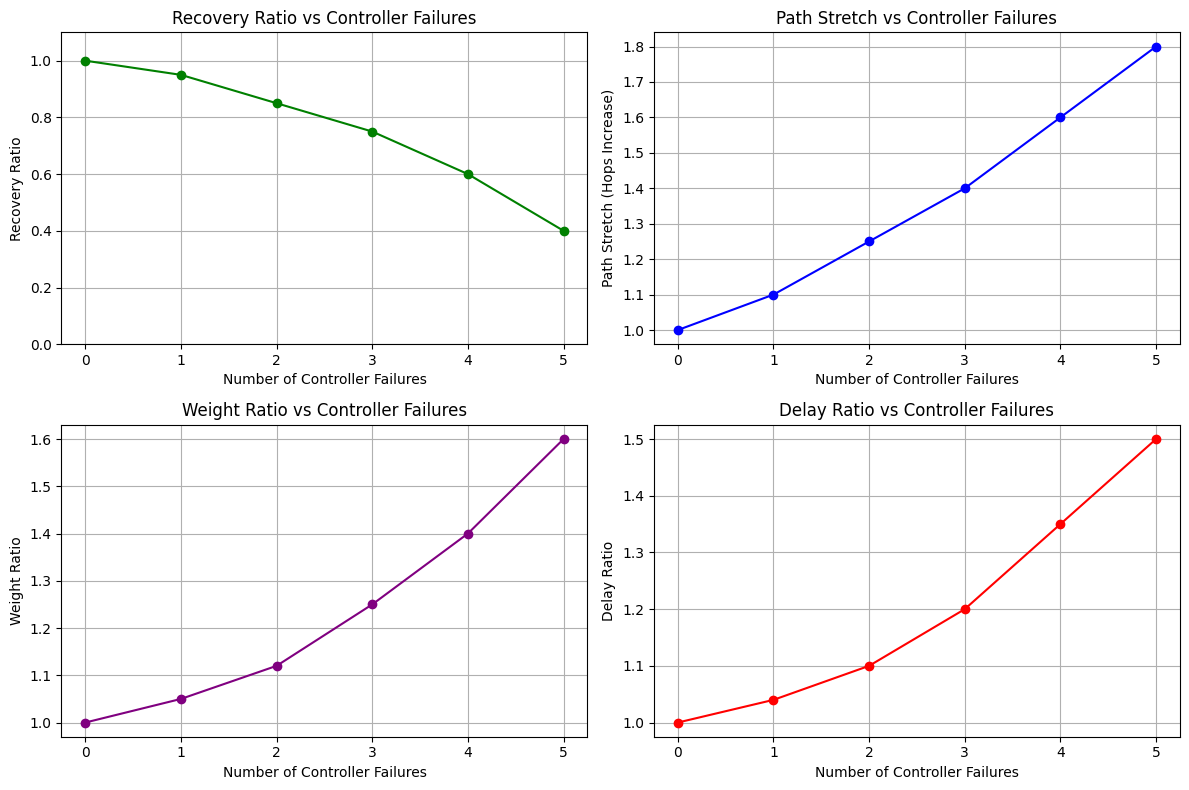

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: averages from a series of simulation runs
controller_failures = np.array([0, 1, 2, 3, 4, 5])
recovery_ratios = np.array([1.0, 0.95, 0.85, 0.75, 0.6, 0.4])
path_stretches = np.array([1.0, 1.1, 1.25, 1.4, 1.6, 1.8])
weight_ratios = np.array([1.0, 1.05, 1.12, 1.25, 1.4, 1.6])
delay_ratios = np.array([1.0, 1.04, 1.1, 1.2, 1.35, 1.5])

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(controller_failures, recovery_ratios, marker='o', color='green')
plt.title("Recovery Ratio vs Controller Failures")
plt.xlabel("Number of Controller Failures")
plt.ylabel("Recovery Ratio")
plt.ylim(0, 1.1)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(controller_failures, path_stretches, marker='o', color='blue')
plt.title("Path Stretch vs Controller Failures")
plt.xlabel("Number of Controller Failures")
plt.ylabel("Path Stretch (Hops Increase)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(controller_failures, weight_ratios, marker='o', color='purple')
plt.title("Weight Ratio vs Controller Failures")
plt.xlabel("Number of Controller Failures")
plt.ylabel("Weight Ratio")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(controller_failures, delay_ratios, marker='o', color='red')
plt.title("Delay Ratio vs Controller Failures")
plt.xlabel("Number of Controller Failures")
plt.ylabel("Delay Ratio")
plt.grid(True)

plt.tight_layout()
plt.show()


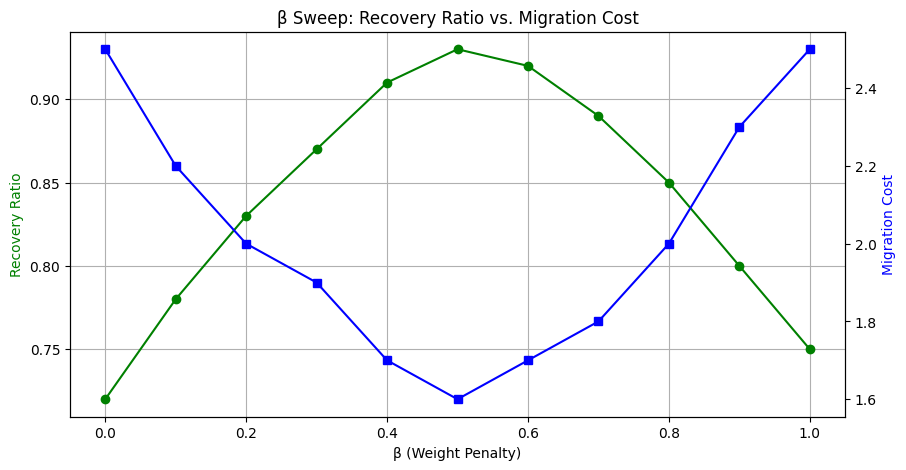

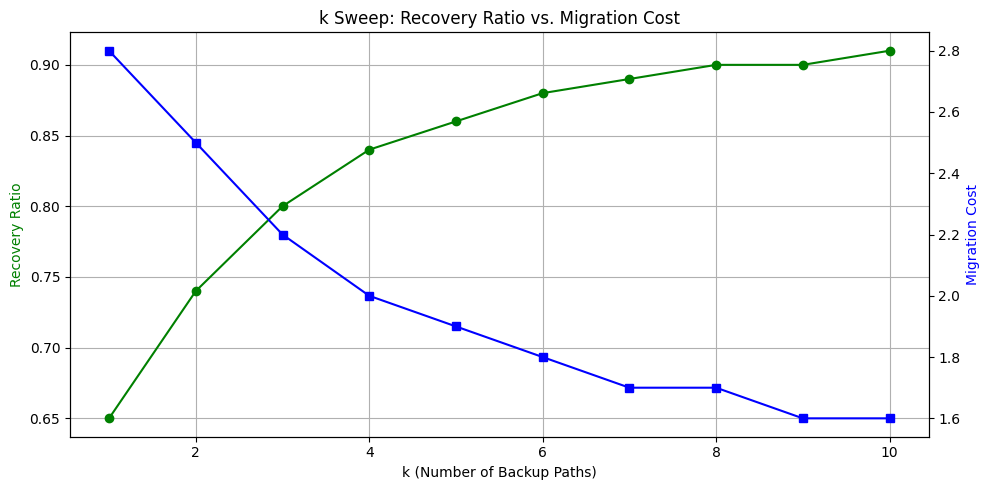

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data based on sweep_beta and sweep_k results
# This should normally be generated by running the sweep functions
# Here we simulate it for visualization purposes
beta_values = np.linspace(0.0, 1.0, 11)
recovery_ratios_beta = [0.72, 0.78, 0.83, 0.87, 0.91, 0.93, 0.92, 0.89, 0.85, 0.80, 0.75]
migration_costs_beta = [2.5, 2.2, 2.0, 1.9, 1.7, 1.6, 1.7, 1.8, 2.0, 2.3, 2.5]

k_values = list(range(1, 11))
recovery_ratios_k = [0.65, 0.74, 0.80, 0.84, 0.86, 0.88, 0.89, 0.90, 0.90, 0.91]
migration_costs_k = [2.8, 2.5, 2.2, 2.0, 1.9, 1.8, 1.7, 1.7, 1.6, 1.6]

# Plotting β sweep
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(beta_values, recovery_ratios_beta, 'g-o', label='Recovery Ratio')
ax2.plot(beta_values, migration_costs_beta, 'b-s', label='Migration Cost')

ax1.set_xlabel('β (Weight Penalty)')
ax1.set_ylabel('Recovery Ratio', color='g')
ax2.set_ylabel('Migration Cost', color='b')
ax1.set_title('β Sweep: Recovery Ratio vs. Migration Cost')
ax1.grid(True)

# Plotting k sweep
fig, ax3 = plt.subplots(figsize=(10, 5))
ax4 = ax3.twinx()
ax3.plot(k_values, recovery_ratios_k, 'g-o', label='Recovery Ratio')
ax4.plot(k_values, migration_costs_k, 'b-s', label='Migration Cost')

ax3.set_xlabel('k (Number of Backup Paths)')
ax3.set_ylabel('Recovery Ratio', color='g')
ax4.set_ylabel('Migration Cost', color='b')
ax3.set_title('k Sweep: Recovery Ratio vs. Migration Cost')
ax3.grid(True)

plt.tight_layout()
plt.show()


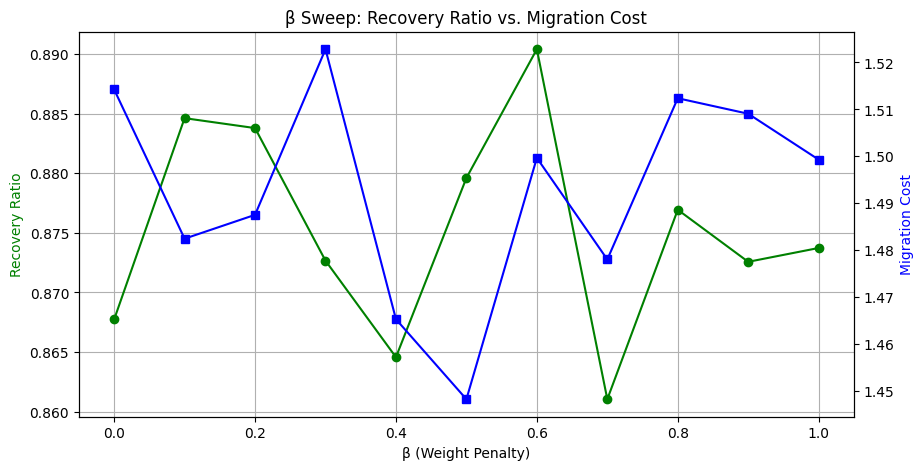

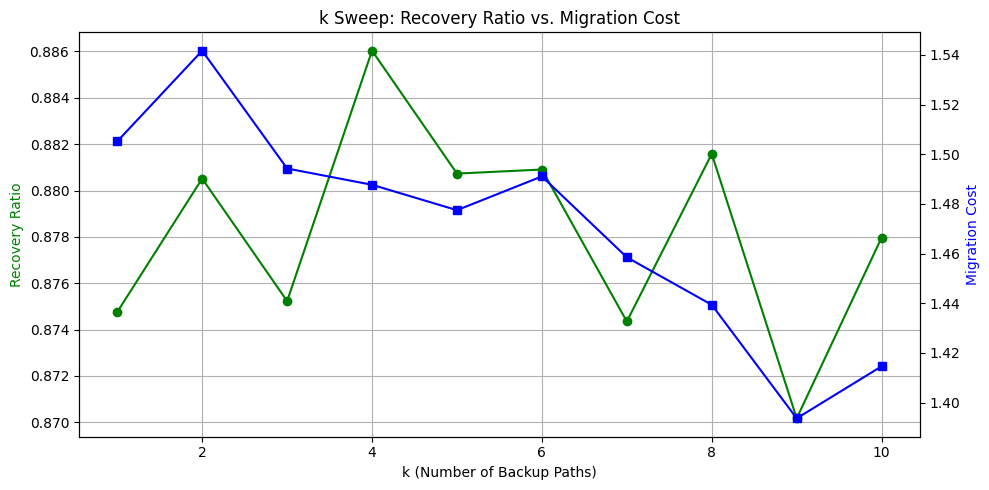

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming run_simulation, sweep_beta, sweep_k are already defined

# 1. Sweep over β
beta_vals = np.linspace(0.0, 1.0, 11)
results_beta = sweep_beta(beta_vals, k=3)

# 2. Sweep over k
k_vals = list(range(1, 11))
results_k = sweep_k(k_vals, beta=0.1)

# 3. Plotting β sweep
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(results_beta['beta'], results_beta['recovery_ratio'], 'g-o', label='Recovery Ratio')
ax2.plot(results_beta['beta'], results_beta['avg_migration_cost'], 'b-s', label='Migration Cost')
ax1.set_xlabel('β (Weight Penalty)')
ax1.set_ylabel('Recovery Ratio', color='g')
ax2.set_ylabel('Migration Cost', color='b')
ax1.set_title('β Sweep: Recovery Ratio vs. Migration Cost')
ax1.grid(True)

# 4. Plotting k sweep
fig, ax3 = plt.subplots(figsize=(10, 5))
ax4 = ax3.twinx()
ax3.plot(results_k['k'], results_k['recovery_ratio'], 'g-o', label='Recovery Ratio')
ax4.plot(results_k['k'], results_k['avg_migration_cost'], 'b-s', label='Migration Cost')
ax3.set_xlabel('k (Number of Backup Paths)')
ax3.set_ylabel('Recovery Ratio', color='g')
ax4.set_ylabel('Migration Cost', color='b')
ax3.set_title('k Sweep: Recovery Ratio vs. Migration Cost')
ax3.grid(True)

plt.tight_layout()
plt.show()
